In [1]:
# importing
import numpy as np
import gzip, os
from urllib.request import urlretrieve
from random import random
from math import exp
from random import seed
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pdb

Now testing to see if we can detect objects within an image

This is the actual semantic segmentation part

In [2]:
## DATA HERE from PASCAL2

import os
import tarfile
import shutil
import urllib.request

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
path='VOC'
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path

  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")

get_archive(path,url)
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import torchvision.transforms as T
import numpy as np


# color (rgb) segmentation maps in the dataset, change to single number in training
VOC_COLORMAP = [
    [0, 0, 0],
    [224, 224, 192],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

# categories, ordering respectivley
VOC_CLASSES = [
    "background",
    "edge",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

In [101]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class VocDataset(Dataset):
  def __init__(self, dir, color_map):
    self.root = os.path.join(dir,'VOCdevkit/VOC2007')
    self.images_dir = os.path.join(self.root,'JPEGImages')
    self.target_dir = os.path.join(self.root,'SegmentationClass') # this should be ground truth
    file_list = os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in open(file_list, "r")]
    self.color_map = color_map

  def colors_to_seg_map(self, seg_RGB):
    # return None
    seg_map = [[1 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])]
    for row in range(len(seg_RGB)):
      for col in range(len(seg_RGB[0])):
        pixel = list(seg_RGB[row][col])
        if pixel not in VOC_COLORMAP:
          print("HELLO BIG PROBLEM HERE")
        id = VOC_COLORMAP.index(pixel)
        seg_map[row][col] = id
    return np.array(seg_map)

    # to look at the seg maps, uncomment
    # print(f"here is the max: {np.max(seg_RGB)}")
    # seg_map = [[[0 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])] for _ in range(len(VOC_COLORMAP))]
    # for row in range(len(seg_RGB)):
    #   for col in range(len(seg_RGB[0])):
    #     pixel = list(seg_RGB[row][col])
    #     id = VOC_COLORMAP.index(pixel)
    #     seg_map[id][row][col] = 1
    # # for i in range(len(seg_map)):
    # #   plt.imshow(seg_map[i])
    # #   plt.show()
    # # seg_maps = tensor(seg_maps)


  def __len__(self):
    return len(self.files)

  def __getitem__(self, index):
    file = self.files[index]
    image_path = os.path.join(self.images_dir, file + ".jpg")
    seg_path = os.path.join(self.target_dir, file + ".png")

    # Load image
    image = Image.open(image_path).convert("RGB")

    # Load segmentation map

    # center_crop = transforms.CenterCrop((224, 224))
    center_crop = transforms.Resize((224, 224), interpolation=Image.NEAREST) # resizing seems to give better results than center crop
    image = center_crop(image)

    pre_seg_RGB = Image.open(seg_path).convert("RGB")
    pre_seg_RGB = center_crop(pre_seg_RGB)
    seg_RGB = np.array(pre_seg_RGB)

    seg_map = self.colors_to_seg_map(seg_RGB)


    # old transformations based on imagenet norm
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))  # ImageNet normalization
    ])

    image = transform(image)


    return image, seg_map
    # return image, seg_map

In [142]:
class FCN32(torch.nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    # Pretrained VGG-16 features (first half of NN)
    # vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
    vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')
    self.features = vgg16.features
    self.n_class = n_classes
    # features = list(vgg16.features.children())
    # self.vgg_features = nn.Sequential(*features)

    """
      Perform upsampling via deconvolution operations
    """

    # self.converge_decode = torch.nn.Sequential(
    #   torch.nn.Conv2d(512, 4096, kernel_size=1),
    #   torch.nn.ReLU(inplace=True),
    #   torch.nn.Dropout(),
    #   torch.nn.Conv2d(4096, 4096, kernel_size=1),
    #   torch.nn.ReLU(inplace=True),
    #   torch.nn.Dropout(),
    #   torch.nn.ConvTranspose2d(4096, 512, kernel_size=4, stride=2, padding=1),
    # )

    self.converge_decode = torch.nn.Sequential(
      # First Convolution Layer
      torch.nn.Conv2d(512, 2048, kernel_size=1),
      torch.nn.ReLU(inplace=True),

      # Second Convolution Layer
      torch.nn.Conv2d(2048, 2048, kernel_size=1),
      torch.nn.ReLU(inplace=True),

      # Upsample with ConvTranspose2d (start with larger kernel sizes)
      torch.nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(1024),
      torch.nn.ReLU(inplace=True),

      # Upsample more
      torch.nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(512),
      torch.nn.ReLU(inplace=True),

      # Final Upsampling
      torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(256),
      torch.nn.ReLU(inplace=True),

      # Further Upsample
      torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
      torch.nn.BatchNorm2d(128),
      torch.nn.ReLU(inplace=True),
    )



    self.final_upsample = torch.nn.ConvTranspose2d(
        128, n_classes, kernel_size=2, stride=2
    )


  def forward(self, x):
    # plt.imshow(x[0].T)
    # plt.show()
    # assert False
    # print("PRE VGL FEATURES", x.size())
    x = self.features(x)
    # print("POST VGL FEATURES", x.size())

    # Upsampling
    # x = self.upscale_encode(x)
    x = self.converge_decode(x)
    # print("POST converge FEATURES", x.size())
    x = self.final_upsample(x)
    # print("POST upsample FEATURES", x.size())

    return x

In [63]:
# seg_maps
torch.max(predicted_classes)
predicted_classes.size()

torch.Size([4, 224, 224])

In [143]:
import torch.optim as optim


# Define the VOC dataset
batch_size = 4
trainset = VocDataset(dir='./', color_map=VOC_COLORMAP)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

class_weights = torch.tensor([0.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])
# Note the class weights, because our images are background dominant, I will punish the model more when it misclassifies anything as background

# FCN-32 model
fcn32_model = FCN32(n_classes=len(VOC_CLASSES))

# google colab gpu if we can
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcn32_model.to(device)

noise_layer = None

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(fcn32_model.parameters(), lr=0.001)
# optimizer = optim.SGD(fcn32_model.parameters(), lr=0.001) # learn rate too high

epochs = 3
for epoch in range(epochs):  # loop over the dataset multiple times
    print(f"epoch {epoch}")
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # print(f"iteration {i}")
        # pdb.set_trace()
        # assert False
        inputs, seg_maps = data

        # Move inputs and segmentation maps to GPU if available
        inputs, seg_maps = inputs.to(device), seg_maps.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = fcn32_model(inputs)

        # uncomment to see feature maps
        # plt.imshow(outputs[0].cpu().detach())
        # plt.imshow(torch.argmax(outputs.cpu(), dim=1)[0])
        # plt.show()
        # plt.imshow(seg_maps[0].cpu())
        # plt.show()
        # print(torch.argmax(outputs))
        # predicted_classes = torch.argmax(outputs, dim=1)


        # print(f"inputs size: {inputs.size()}")
        # print(f"outputs size: {outputs.size()}")
        # print(f"predicted_classes size: {predicted_classes.size()}")
        # print(f"seg_maps size: {seg_maps.size()}")

        loss = criterion(outputs, seg_maps.long())
        # loss = criterion(predicted_classes, seg_maps.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 0 and i != 0:    # Print every 200 mini-batches
            print(f'Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(trainloader)}], Loss: {running_loss / 10:.4f}')
            running_loss = 0.0

print('Finished Training')


epoch 0
Epoch [1/3], Batch [11/106], Loss: 3.1511
Epoch [1/3], Batch [21/106], Loss: 2.4954
Epoch [1/3], Batch [31/106], Loss: 2.2479
Epoch [1/3], Batch [41/106], Loss: 2.2384
Epoch [1/3], Batch [51/106], Loss: 1.9349
Epoch [1/3], Batch [61/106], Loss: 2.0397
Epoch [1/3], Batch [71/106], Loss: 2.0649
Epoch [1/3], Batch [81/106], Loss: 1.9635
Epoch [1/3], Batch [91/106], Loss: 2.2181
Epoch [1/3], Batch [101/106], Loss: 2.0677
epoch 1
Epoch [2/3], Batch [11/106], Loss: 2.7681
Epoch [2/3], Batch [21/106], Loss: 1.9457
Epoch [2/3], Batch [31/106], Loss: 2.0313
Epoch [2/3], Batch [41/106], Loss: 1.9427
Epoch [2/3], Batch [51/106], Loss: 2.0157
Epoch [2/3], Batch [61/106], Loss: 2.0394
Epoch [2/3], Batch [71/106], Loss: 2.0466
Epoch [2/3], Batch [81/106], Loss: 1.9383
Epoch [2/3], Batch [91/106], Loss: 1.8280
Epoch [2/3], Batch [101/106], Loss: 2.0499
epoch 2
Epoch [3/3], Batch [11/106], Loss: 2.2319
Epoch [3/3], Batch [21/106], Loss: 2.0264
Epoch [3/3], Batch [31/106], Loss: 2.1871
Epoch [3

In [145]:
torch.save(fcn32_model.state_dict(), "fcn32_model.pth")
print("Model saved to fcn32_model.pth")

Model saved to fcn32_model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


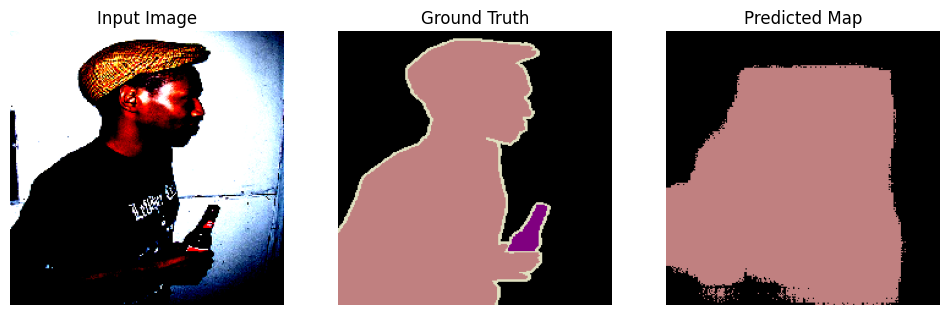

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.29591836734693877


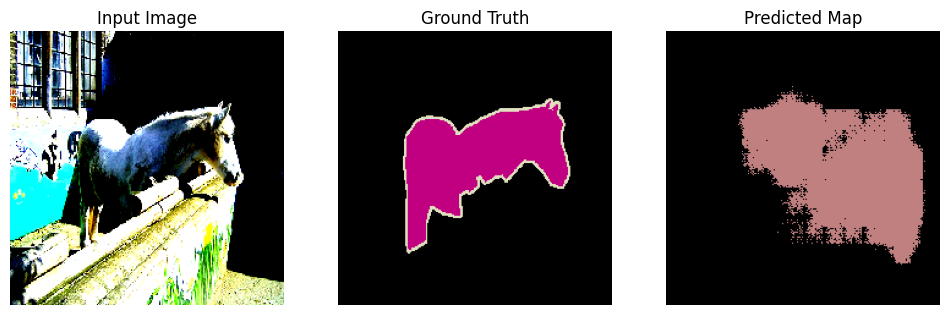

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.3202327806122449


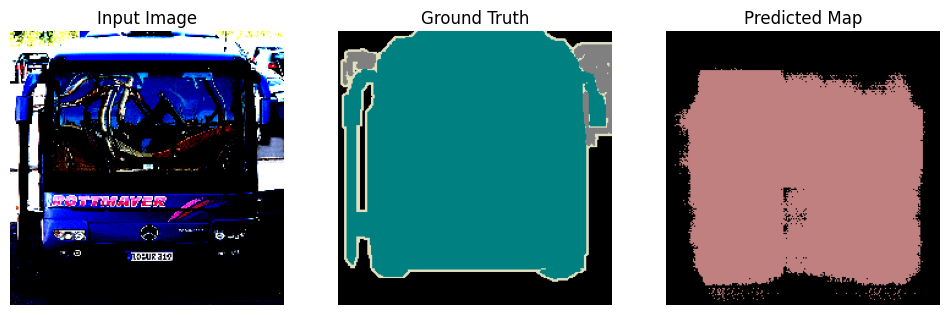

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.169412].


CALCULATED IOU: 0.8261320153061225


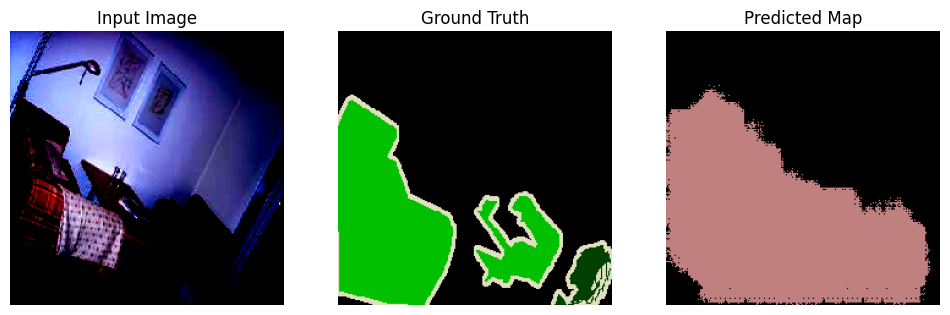

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.5128547512755102


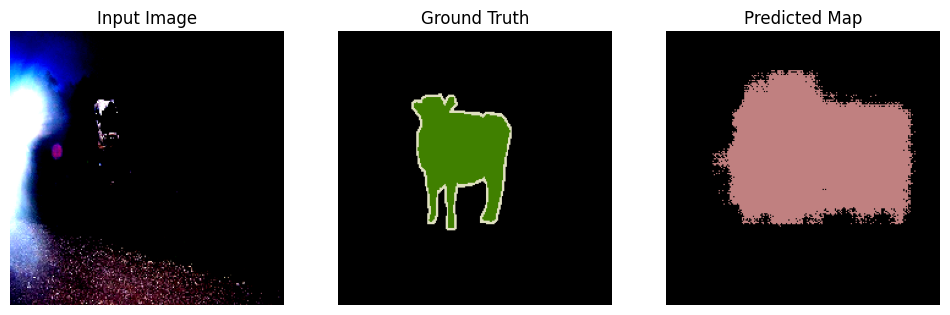

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].


CALCULATED IOU: 0.302913743622449


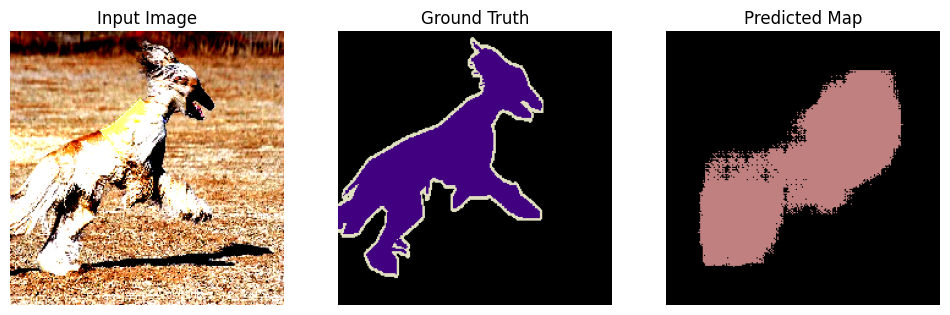

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.37252869897959184


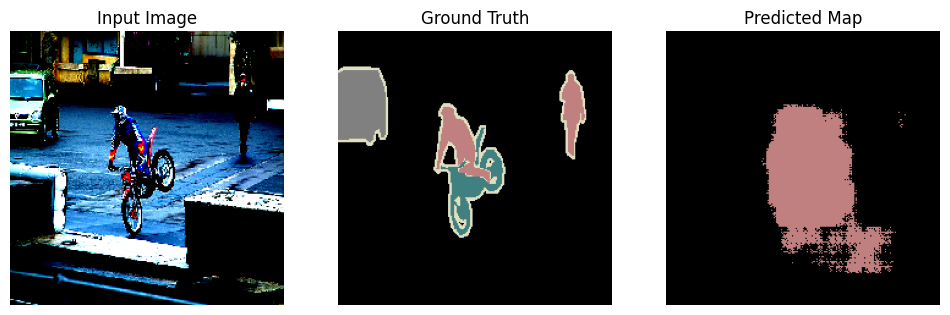

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.21334901147959184


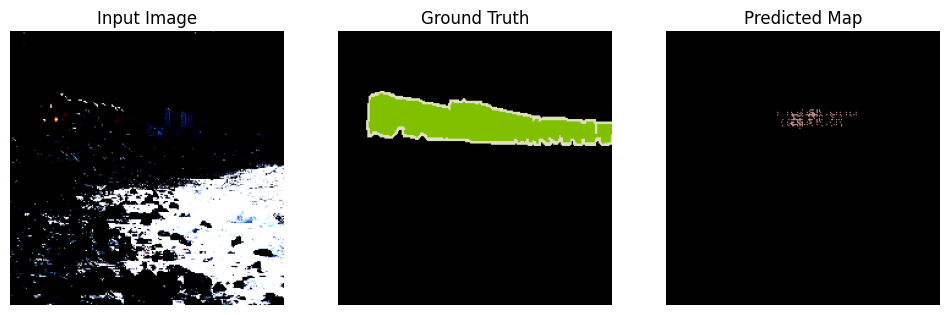

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.11467633928571429


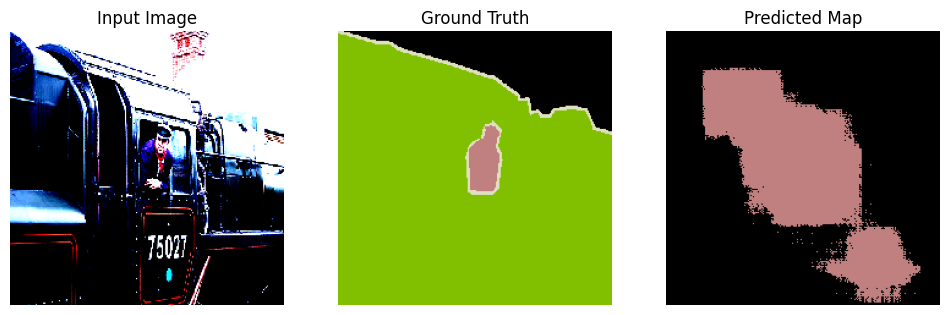

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


CALCULATED IOU: 0.8174625318877551


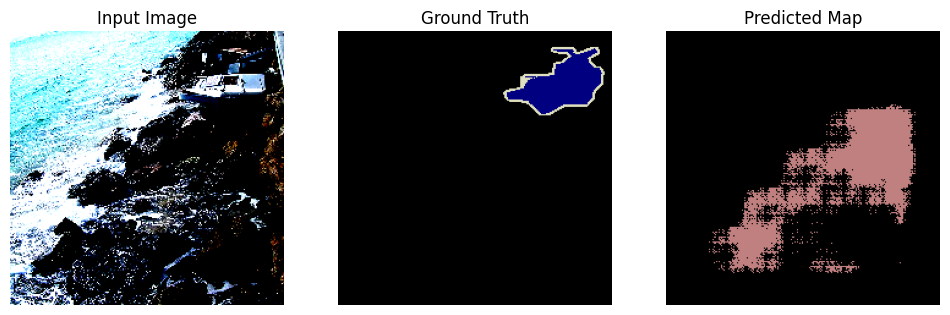

CALCULATED IOU: 0.20364317602040816
The mean iou across 10 sample images is 0.39797114158163266.


In [144]:
# Define the test dataset
testset = VocDataset(dir='./', color_map=VOC_COLORMAP)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

# Define a function to calculate IoU
def calculate_iou(pred, target):
  total_pix = len(pred) * len(pred[0])
  errors = 0
  for i in range(len(pred)):
    for j in range(len(pred[0])):
      if (pred[i][j] != target[i][j]):
        errors += 1
  return errors / total_pix

def collapse(detensor):
  # seg_map is like this [[[0 for _ in range(seg_RGB.shape[1])] for _ in range(seg_RGB.shape[0])] for _ in range(len(VOC_COLORMAP))]
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  len_detensor = len(detensor)

  for row in range(224):
    for col in range(224):
      max_prob = -1.0
      max_layer = -1.0
      for layer_i in range(len_detensor):
        # print(f"checking layer {layer_i}")
        pixel = detensor[layer_i][row][col]
        # print(f"probability {pixel} found on layer {layer_i}")
        if pixel > max_prob:
          max_prob = pixel
          max_layer = layer_i
      # print(f"max layer selected: {max_layer}")
      final[row][col] = VOC_COLORMAP[max_layer]

  return final

def seg_map_format(seg_map):
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  for row in range(224):
    for col in range(224):
      final[row][col] = VOC_COLORMAP[seg_map[row][col]]
  return final

def seg_map_format(seg_map):
  final = [[[255 for _ in range(3)] for _ in range(224)] for _ in range(224)]
  for row in range(224):
    for col in range(224):
      final[row][col] = VOC_COLORMAP[seg_map[row][col]]
  return final


# Initialize lists to store input images, segmentation maps, and predicted maps
input_images = []
ground_truths = []
predicted_maps = []
list_for_iou = []

counter = 0

# Perform inference
fcn32_model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, seg_maps in testloader:
        # Move images and segmentation maps to GPU if available
        images, seg_maps = images.to(device), seg_maps.to(device)

        # Run model inference
        outputs = fcn32_model(images)
        # print(outputs.size())
        # print(outputs[0])
        # assert False

        # Get predicted class indices
        pred_indices = torch.argmax(outputs, dim=1)
        # print(np.average(pred_indices.cpu().numpy()))

        # Convert predicted indices to segmentation maps
        # predicted_maps.append(pred_indices.cpu().numpy())
        # predicted_maps.append(final)
        predicted_maps.append(seg_map_format(pred_indices[0]))

        # Store input images and ground truth segmentation maps
        input_images.append(images[0].cpu().numpy())
        ground_truths.append(seg_map_format(seg_maps[0].cpu().numpy()))

        list_for_iou.append((pred_indices[0], seg_maps[0].cpu().numpy()))

        # break
        counter = counter + 1
        if counter == 10:
          break


# Visualize the results
import matplotlib.pyplot as plt
running_iou = 0.0

# input, truth, and prediction
def visualize_result(image, gt, pred, idx, iou_p):
  global running_iou
  plt.figure(figsize=(12, 4))

  # Input
  plt.subplot(1, 3, 1)
  plt.imshow(image.transpose(1, 2, 0))
  plt.title("Input Image")
  plt.axis('off')

  # Ground
  plt.subplot(1, 3, 2)
  plt.imshow(gt, vmin=0, vmax=len(VOC_CLASSES)-1)
  plt.title("Ground Truth")
  plt.axis('off')

  # Predicted
  plt.subplot(1, 3, 3)
  plt.imshow(pred, vmin=0, vmax=len(VOC_CLASSES)-1)
  plt.title("Predicted Map")
  plt.axis('off')

  plt.show()

  iou = calculate_iou(iou_p[0], iou_p[1])
  print(f"CALCULATED IOU: {iou}")
  running_iou += iou


# Visualize a random sample of the results
for i in range(counter):
  visualize_result(input_images[i], ground_truths[i], predicted_maps[i], i, list_for_iou[i])

print(f"The mean iou across {counter} sample images is {running_iou / counter}.")